<a href="https://colab.research.google.com/github/umermaher/DS_A-CEP/blob/main/starter_synthetic_financial_datasets_cd6449a6_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [3]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [4]:
nRowsRead = 2000 # specify 'None' if want to read whole file
# PS_20174392719_1491204439457_log.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/PS_20174392719_1491204439457_log.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'PS_20174392719_1491204439457_log.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2000 rows and 11 columns


Let's take a quick look at what the data looks like:

In [5]:
df1.head(100)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
95,1,TRANSFER,710544.77,C835773569,0.0,0.00,C1359044626,738531.50,16518.36,0,0
96,1,TRANSFER,581294.26,C843299092,0.0,0.00,C1590550415,5195482.15,19169204.93,0,0
97,1,TRANSFER,11996.58,C605982374,0.0,0.00,C1225616405,40255.00,0.00,0,0
98,1,PAYMENT,2875.10,C1412322831,15443.0,12567.90,M1651262695,0.00,0.00,0,0


Distribution graphs (histogram/bar graph) of sampled columns:

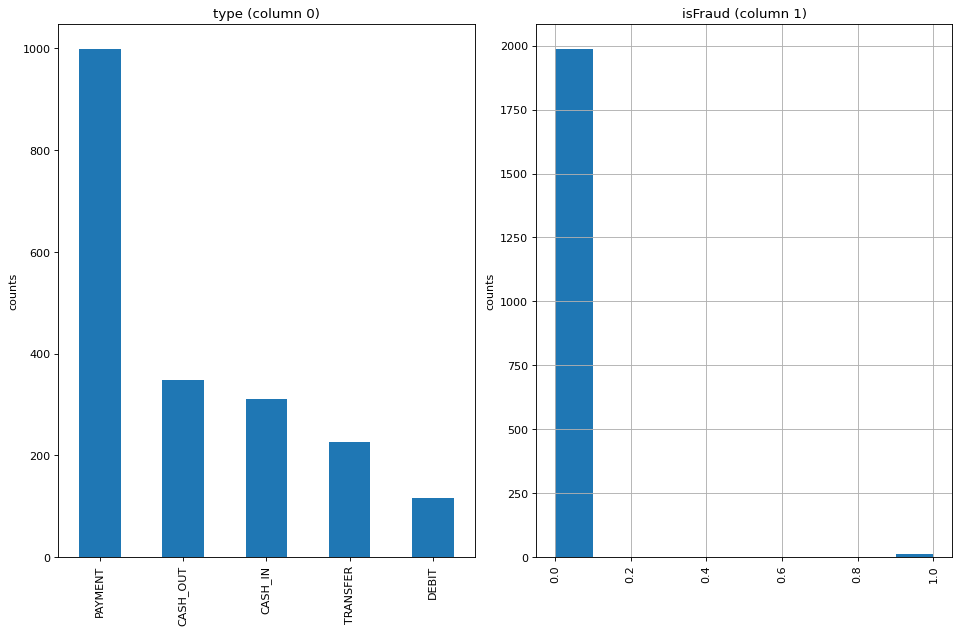

In [6]:
plotPerColumnDistribution(df1, 10, 5)

Correlation matrix:

<ipython-input-3-a0343c621274>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN
<ipython-input-3-a0343c621274>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


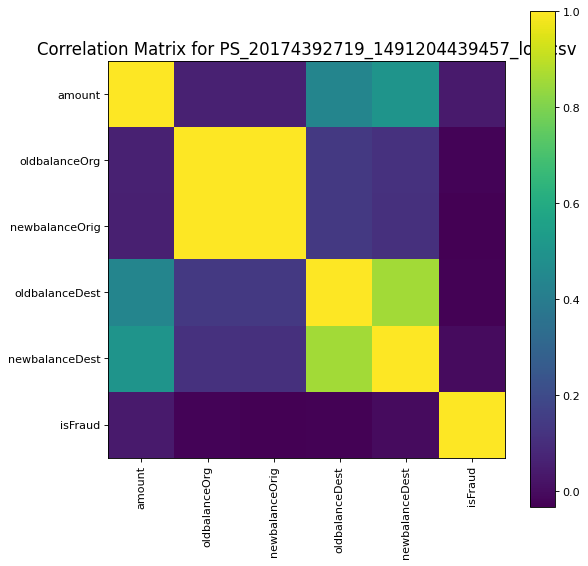

In [7]:
plotCorrelationMatrix(df1, 8)

Scatter and density plots:

<ipython-input-9-45d7bdcfca59>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


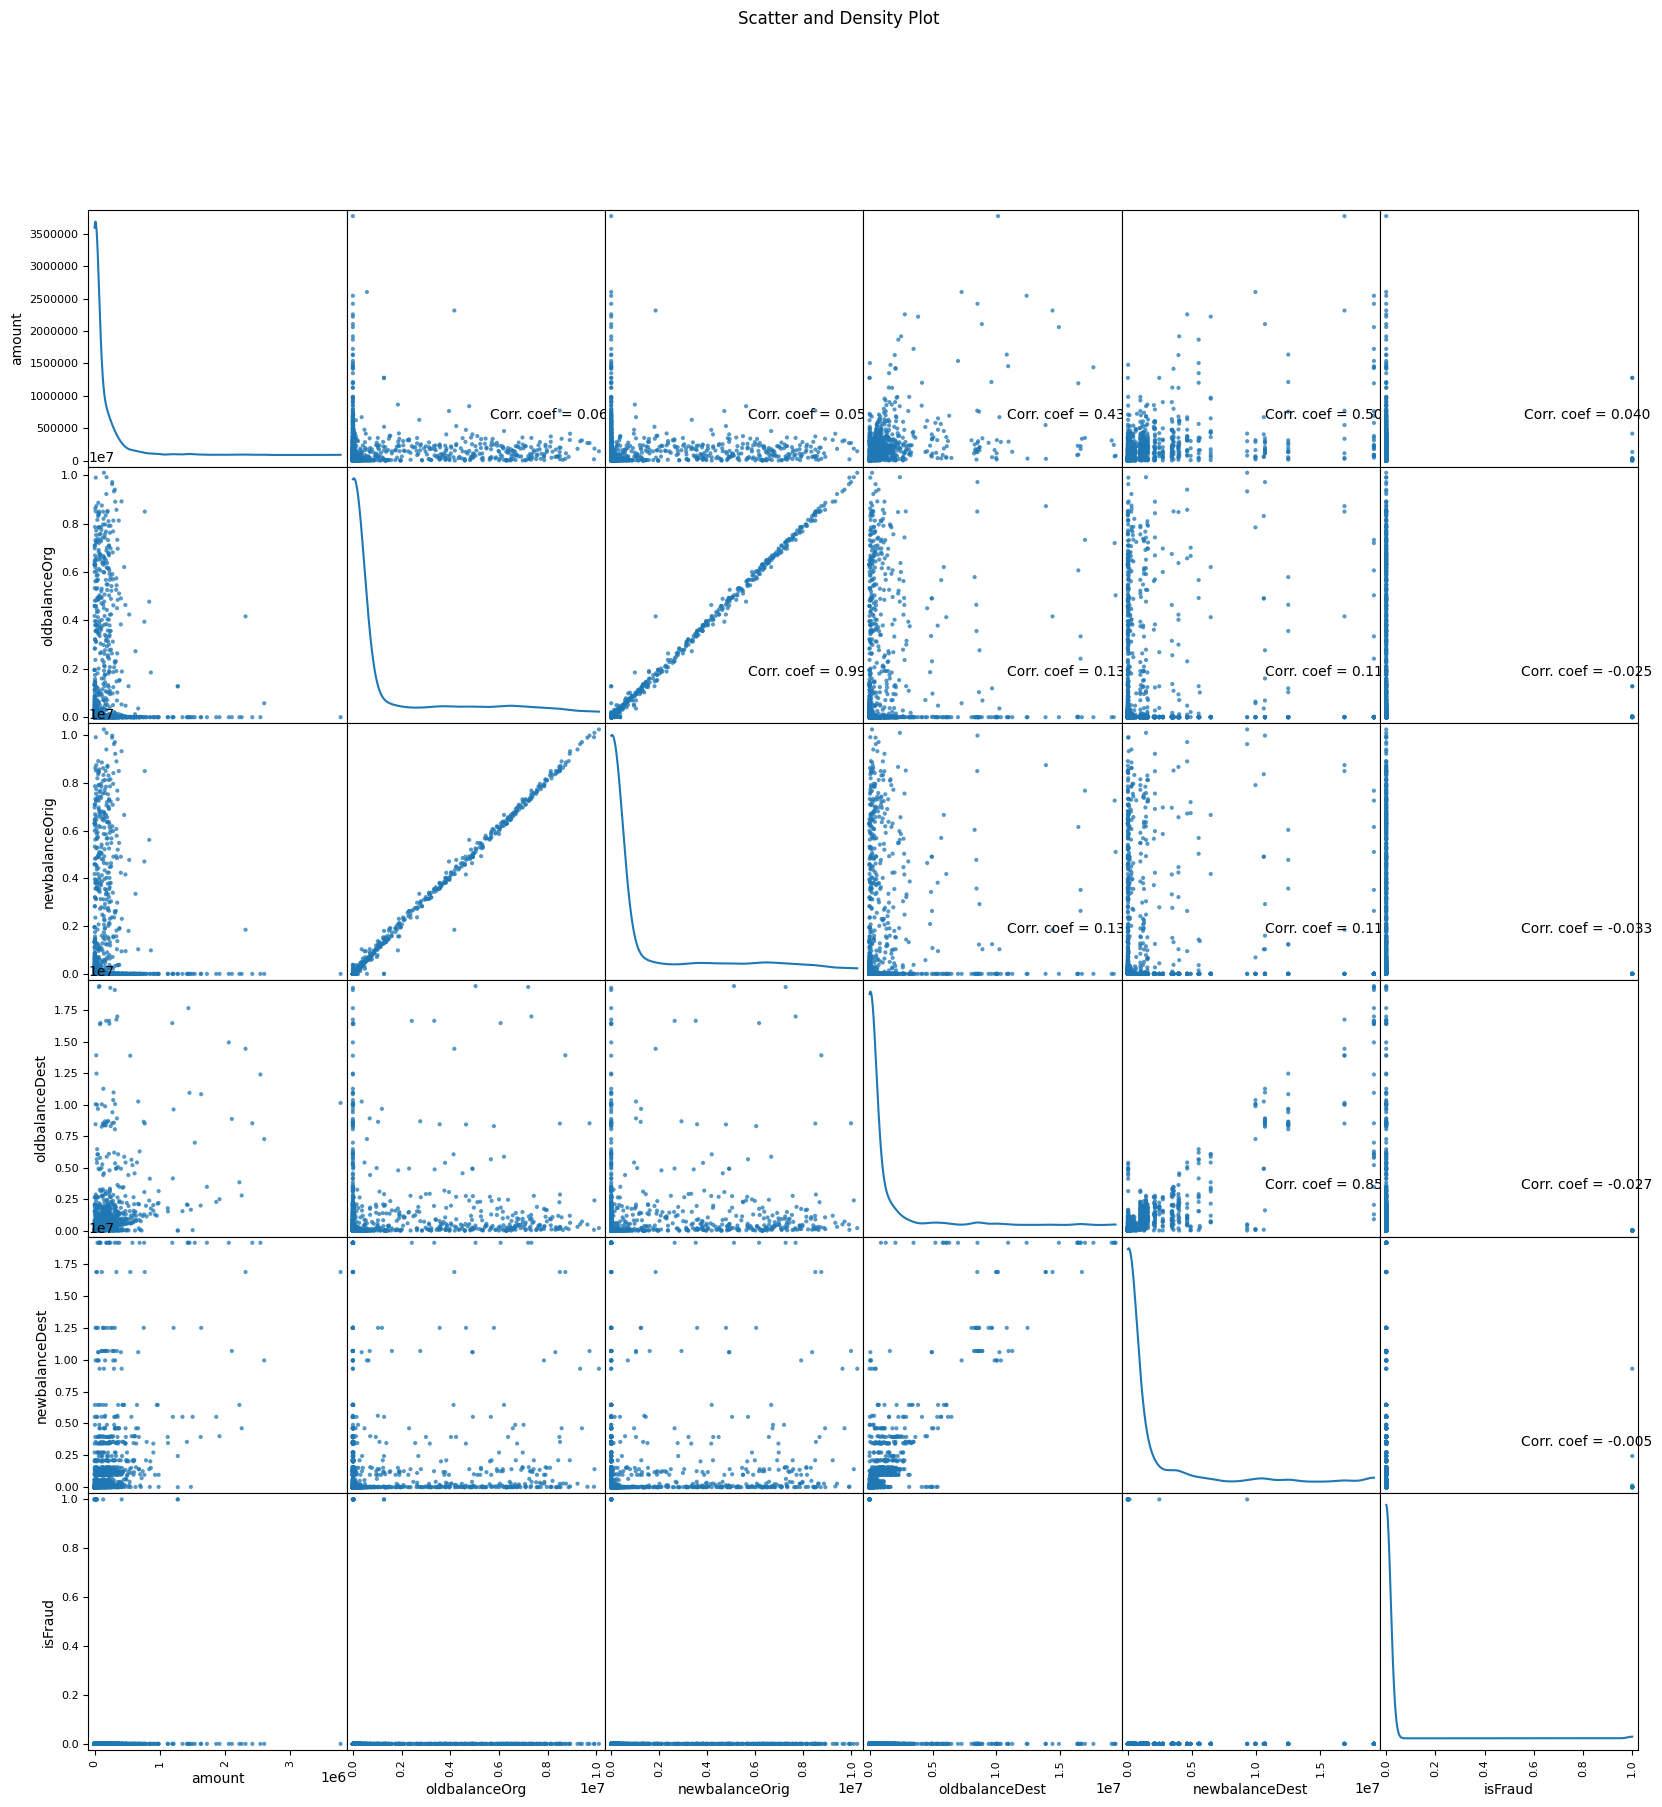

In [10]:
plotScatterMatrix(df1, 20, 10)


In [15]:
df1.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

# Apply The Model

In [18]:

# Perform one-hot encoding
encoder = OneHotEncoder(sparse=False)
type_encoded = encoder.fit_transform(df1[['type']])
type_encoded_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']))

df1 = pd.get_dummies(df1, columns=['type'], prefix=['type'])


# # Concatenate the one-hot encoded features and drop the original 'type' column
# df1 = pd.concat([df1, type_encoded_df], axis=1)
# df1.drop(['nameOrig'], axis=1, inplace=True)

# for start
# Get column names that start with 'nameOrig_'
columns_to_remove = [col for col in df1.columns if col.startswith('nameOrig')]
# Drop the columns
df1.drop(columns=columns_to_remove, inplace=True)
# df1 = df1.drop(['type'], axis=1)
# df1 = df1.drop(['nameDest'], axis=1)


# Select features (X) and target (y)
X = df1.drop(['isFraud'], axis=1)
y = df1['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict using the model
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Additional metrics and classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.995
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       397
           1       1.00      0.33      0.50         3

    accuracy                           0.99       400
   macro avg       1.00      0.67      0.75       400
weighted avg       1.00      0.99      0.99       400



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
